In [1]:
import numpy as np
from sklearn import datasets
import pydotplus as dot
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
dataset = datasets.load_iris() #loading iris dataset...

X = dataset.data  #extracting input data
Y = dataset.target  #extrating output data
feature_names = dataset.feature_names  #extracting feature names
target_names = dataset.target_names  #extracting target names


#providing feature number to each feature names
feature_dict = {}  
for i in range(len(feature_names)):  
    feature_dict[i] = feature_names[i]  

#providing taget number to each target names
target_dict = {}
for i in range(len(target_names)):
    target_dict[i] = target_names[i]   

X_df = pd.DataFrame(X,columns=feature_dict.keys())  #creating dataset for input data..

Y_df = pd.DataFrame(Y,columns=["Output"])  #creating dataset fo output data


In [3]:
#Entropy function calculates the entropy...
def entropy(y):
    
    entropy_value = 0
    count_dict = y["Output"].value_counts().to_dict()  #calculating count of each target values in output y
    total_count = y["Output"].count()  #calculating total count
    
    for classes in count_dict:  #iterating through each target values

        entropy_value -= (count_dict[classes]/total_count) * (np.log(count_dict[classes]/total_count))  #calculating the summation of  Pi(logPi) of each target to get the final entropy value...
        
    return entropy_value   #returning the final  entropy value...
    

In [4]:
#this function is used for calculating the information gain and split number...

def feature_split_2(X_feature_set,Y,mid_value):
    
    mod_y = Y.values.size  #total number of samples..
    
    info = 0
    split = 0
    
    
    for category in range(2):  #iterating 2 times...once less than mid value...once greater than the mid value..
        
        if category == 0 :
            Y_select = Y[X_feature_set <= mid_value]  #filtering out the Y ...having X value less than the mid values
            
        if category == 1:
            Y_select = Y[X_feature_set > mid_value]   #filtering out the Y ..having X value greater than the mid values
        
        mod_y_select = Y_select.values.size  #calcuting the length of fitered out Y..ie Y_select

        ratio = mod_y_select/mod_y  #finding it's ratio
        
        info += ratio * entropy(Y_select)  #calculating info gain
        split -= ratio * np.log(ratio)  #calculating split num..
        
    return info,split

In [5]:
#this function returns the info gain..split num...mid_value for a particular feature..
def feature_split(X,Y,feature_num):  
    
    X_feature_set = X[feature_num] #extracting the particular feature column from the dataset...
    feature_values = list(set(X_feature_set.values))  #filtering the different values of that column..
    feature_values.sort()  #sorting the distinct values list..
    
    mid_feature_values = []
    
    for value in range(len(feature_values) -1 ):  #iterating over the feature value list...
        mid_feature_values.append((feature_values[value] + feature_values[value+1])/2)   #storing the mid value between each values in feature value list..
    
    
    min_info = np.inf
    min_split = 0
    min_mid_value = 0

    for mid_value in mid_feature_values:  #iterating over each mid values...to find out the best one..
        
        #finding out the info...split ..for each mid value..
        info,split = feature_split_2(X_feature_set,Y,mid_value)
        
        if info < min_info:  #keeping the best splits...
            min_info = info
            min_mid_value = mid_value
            min_split = split
    
    return min_info,min_split,min_mid_value  #returning the best once..
            

In [6]:

def tree(X, Y, feature_dict, target_dict, level = 0):
    
    Node = {}  #creating node ....before each split...in this dictionary all the important attributes will be kept ...
    Node["Level"] = level  
    
    print("Level", level)
        
    count_dict = Y["Output"].value_counts().to_dict()   #calculating the count of each target values...
    
    Node["Total Number of Samples"] = Y["Output"].count()  #total number of samples...or data points..
    print("Total Number of Samples = ", Y["Output"].count())
    
    Node["Count of Each Targets"] = {}  #dictionary to store the count of each target values...
    for target in count_dict:    #iterating over the target count dictionary and assigning values to the dictionary..
        
        print("Count of", target,"(",target_dict[target], ") is", count_dict[target])
        Node["Count of Each Targets"][target_dict[target]] = count_dict[target]  
   
    Entropy = entropy(Y)  #calculating entropy before spliting..
    Node["Entropy"] = Entropy  
    print("Current Entropy is ", Entropy)
    
    Node["Max Target"] = Y["Output"].max()   #target having maximum number of count.. 
    
    if len(list(set(Y["Output"]))) == 1 or len(list(X.columns)) == 0:  #checking weather the node is leaf or not..
        Node["Leaf"] = True #to find out weather the node is leaf or not...
        print("Reached leaf Node")
        print("------------------------------------------------------------------")
        print()
        return Node
    
    
    Node["Leaf"] = False
    
    best_feature = None 
    best_info = -np.inf  
    best_split = 1  
    best_mid_value = None 
    
    for feature in list(X.columns):  #iterting over each feature ......
        
        info, split, mid_value = feature_split(X, Y, feature)  #calculating the info gain..split number...mid_value(upon which feature will be splitted into 2 parts)...for each feature...
    
        if info/split > best_info/best_split :  #storing the feature having better gain ratio..ie info gain/split number
            best_feature = feature  #feature upon which ..we will be spliting
            best_info = info     #info gain of that feature 
            best_split = split     #split number of that feature 
            best_mid_value = mid_value   #mid value of that feature set..around which we will be dividing the feature set into two parts..

    
    print("Splitting on feature ",feature_dict[best_feature] ," with gain ratio ", best_info/best_split)
    Node["Gain Ratio"] = best_info/best_split  #storing the gain ratio...
    
    Node["Selected Feature Number"] = best_feature  
    Node["Selected Feature Name"] = feature_dict[best_feature]
    Node["Mid Value"] = best_mid_value
    print("------------------------------------------------------------------")
    print()
    
    bool_set_1 = X[best_feature] <= best_mid_value  #extracting the values of the best_feature ...which are less than equal to the mid value...and storing it in the form of boolean array..
    bool_set_2 = X[best_feature] > best_mid_value  #extracting the values of the best_feature ...which are greater than the mid value...and storing it in the form of boolean array..
    
    X = X.drop([best_feature],axis=1)  #droping the best_feature column from the dataset....to avoid it's use in further splitting..

    for sets in range(2):  #iterating 2 times ..once when the split condition is true ....another when split condition is false..
        
        if sets == 0: 
            #extracting...datapoints points having best feature value ..less than equal to mid value..ie...using bool_set..1
            X_split = X[bool_set_1]  
            Y_split = Y[bool_set_1]
            
        if sets == 1:
            #extracting..datapoints points having best feature value ..greater than mid value..ie...using bool_set..2
            X_split = X[bool_set_2]
            Y_split = Y[bool_set_2]
            
        Node[sets] = tree(X_split, Y_split, feature_dict, target_dict, level + 1)  #calling the same function for the split's that we made..and storing it in the Node dictionary..where key 0 indicates True(in favour of the cond..)...and key 1..means False(opposing the condition..)
       
    return Node


In [7]:
main_fit_dict = tree(X_df, Y_df, feature_dict, target_dict)  #calling the above function...it returns the node dictionary...which contains the details of each node in detail...stored in recursive fashion..

Level 0
Total Number of Samples =  150
Count of 2 ( virginica ) is 50
Count of 1 ( versicolor ) is 50
Count of 0 ( setosa ) is 50
Current Entropy is  1.0986122886681096
Splitting on feature  sepal width (cm)  with gain ratio  1.6152778872487885
------------------------------------------------------------------

Level 1
Total Number of Samples =  113
Count of 1 ( versicolor ) is 49
Count of 2 ( virginica ) is 45
Count of 0 ( setosa ) is 19
Current Entropy is  1.028774126223425
Splitting on feature  sepal length (cm)  with gain ratio  1.308650808291997
------------------------------------------------------------------

Level 2
Total Number of Samples =  24
Count of 0 ( setosa ) is 19
Count of 1 ( versicolor ) is 4
Count of 2 ( virginica ) is 1
Current Entropy is  0.6159905783211985
Splitting on feature  petal length (cm)  with gain ratio  0.20371768856717126
------------------------------------------------------------------

Level 3
Total Number of Samples =  19
Count of 0 ( setosa ) is 

BONUS PART.......Actual Tree Implementation

In [14]:
"""this function prepares the content to be printed inside each box or node in the diagram...
it takes the help of the dictionary that is returned by the tree function.."""

def node_content(node):
    content = ""   #initiating empty string
    #concatenating different features of that particular node into that string...
    
    content += "No. of Samples = " + str(node['Total Number of Samples']) + "\n\n"
    
    for targets in node['Count of Each Targets'].keys():
        content += "Count of " + targets + " = " + str(node['Count of Each Targets'][targets]) + "\n"
        
    content += "Current Entropy = " + str(node['Entropy']) + "\n\n"
        
    if not node['Leaf'] :
        content += "Gain Ratio = " + str(node['Gain Ratio']) + "\n\n"
        content += node['Selected Feature Name'] + " <= " + str(node['Mid Value']) + "\n"
        
    return content   #returning the final content...

In [15]:
"""this function actually designs the tree..."""

def design_graph(node,graph):
    
    parent = node_content(node)  #pulling out the content of the present node...
    
    for items in node.keys():  #iterating through all the keys of that node...
        if items == 0:   #connecting parent with child node...when  the key is 0...(1st child....when condition is true..)
            child_1 = node_content(node[0])  #pulling out the content of child node
            graph_edge = dot.Edge(parent, child_1, label = True)  #forming the edge between them..
            graph.add_edge(graph_edge)  #adding edge between parent and child..
            design_graph(node[0],graph)   #recursively calling the function to do the same thing ...considering child as parent node...
            
        if items == 1:  #this is child 2...everything is same..as explained above...
            child_2 = node_content(node[1])
            graph_edge = dot.Edge(parent, child_2, label = False)
            graph.add_edge(graph_edge)
            design_graph(node[1],graph)
     
    return graph  #return the final graph....


In [16]:
graph_structure = dot.Dot(graph_type = "digraph")  
main_graph = design_graph(main_fit_dict, graph_structure)  #calling the above function...
main_graph.write_png("iris_tree.png")  #writing the graph to a png file...
print("Created... iris_tree.png file....")

Created... iris_tree.png file....


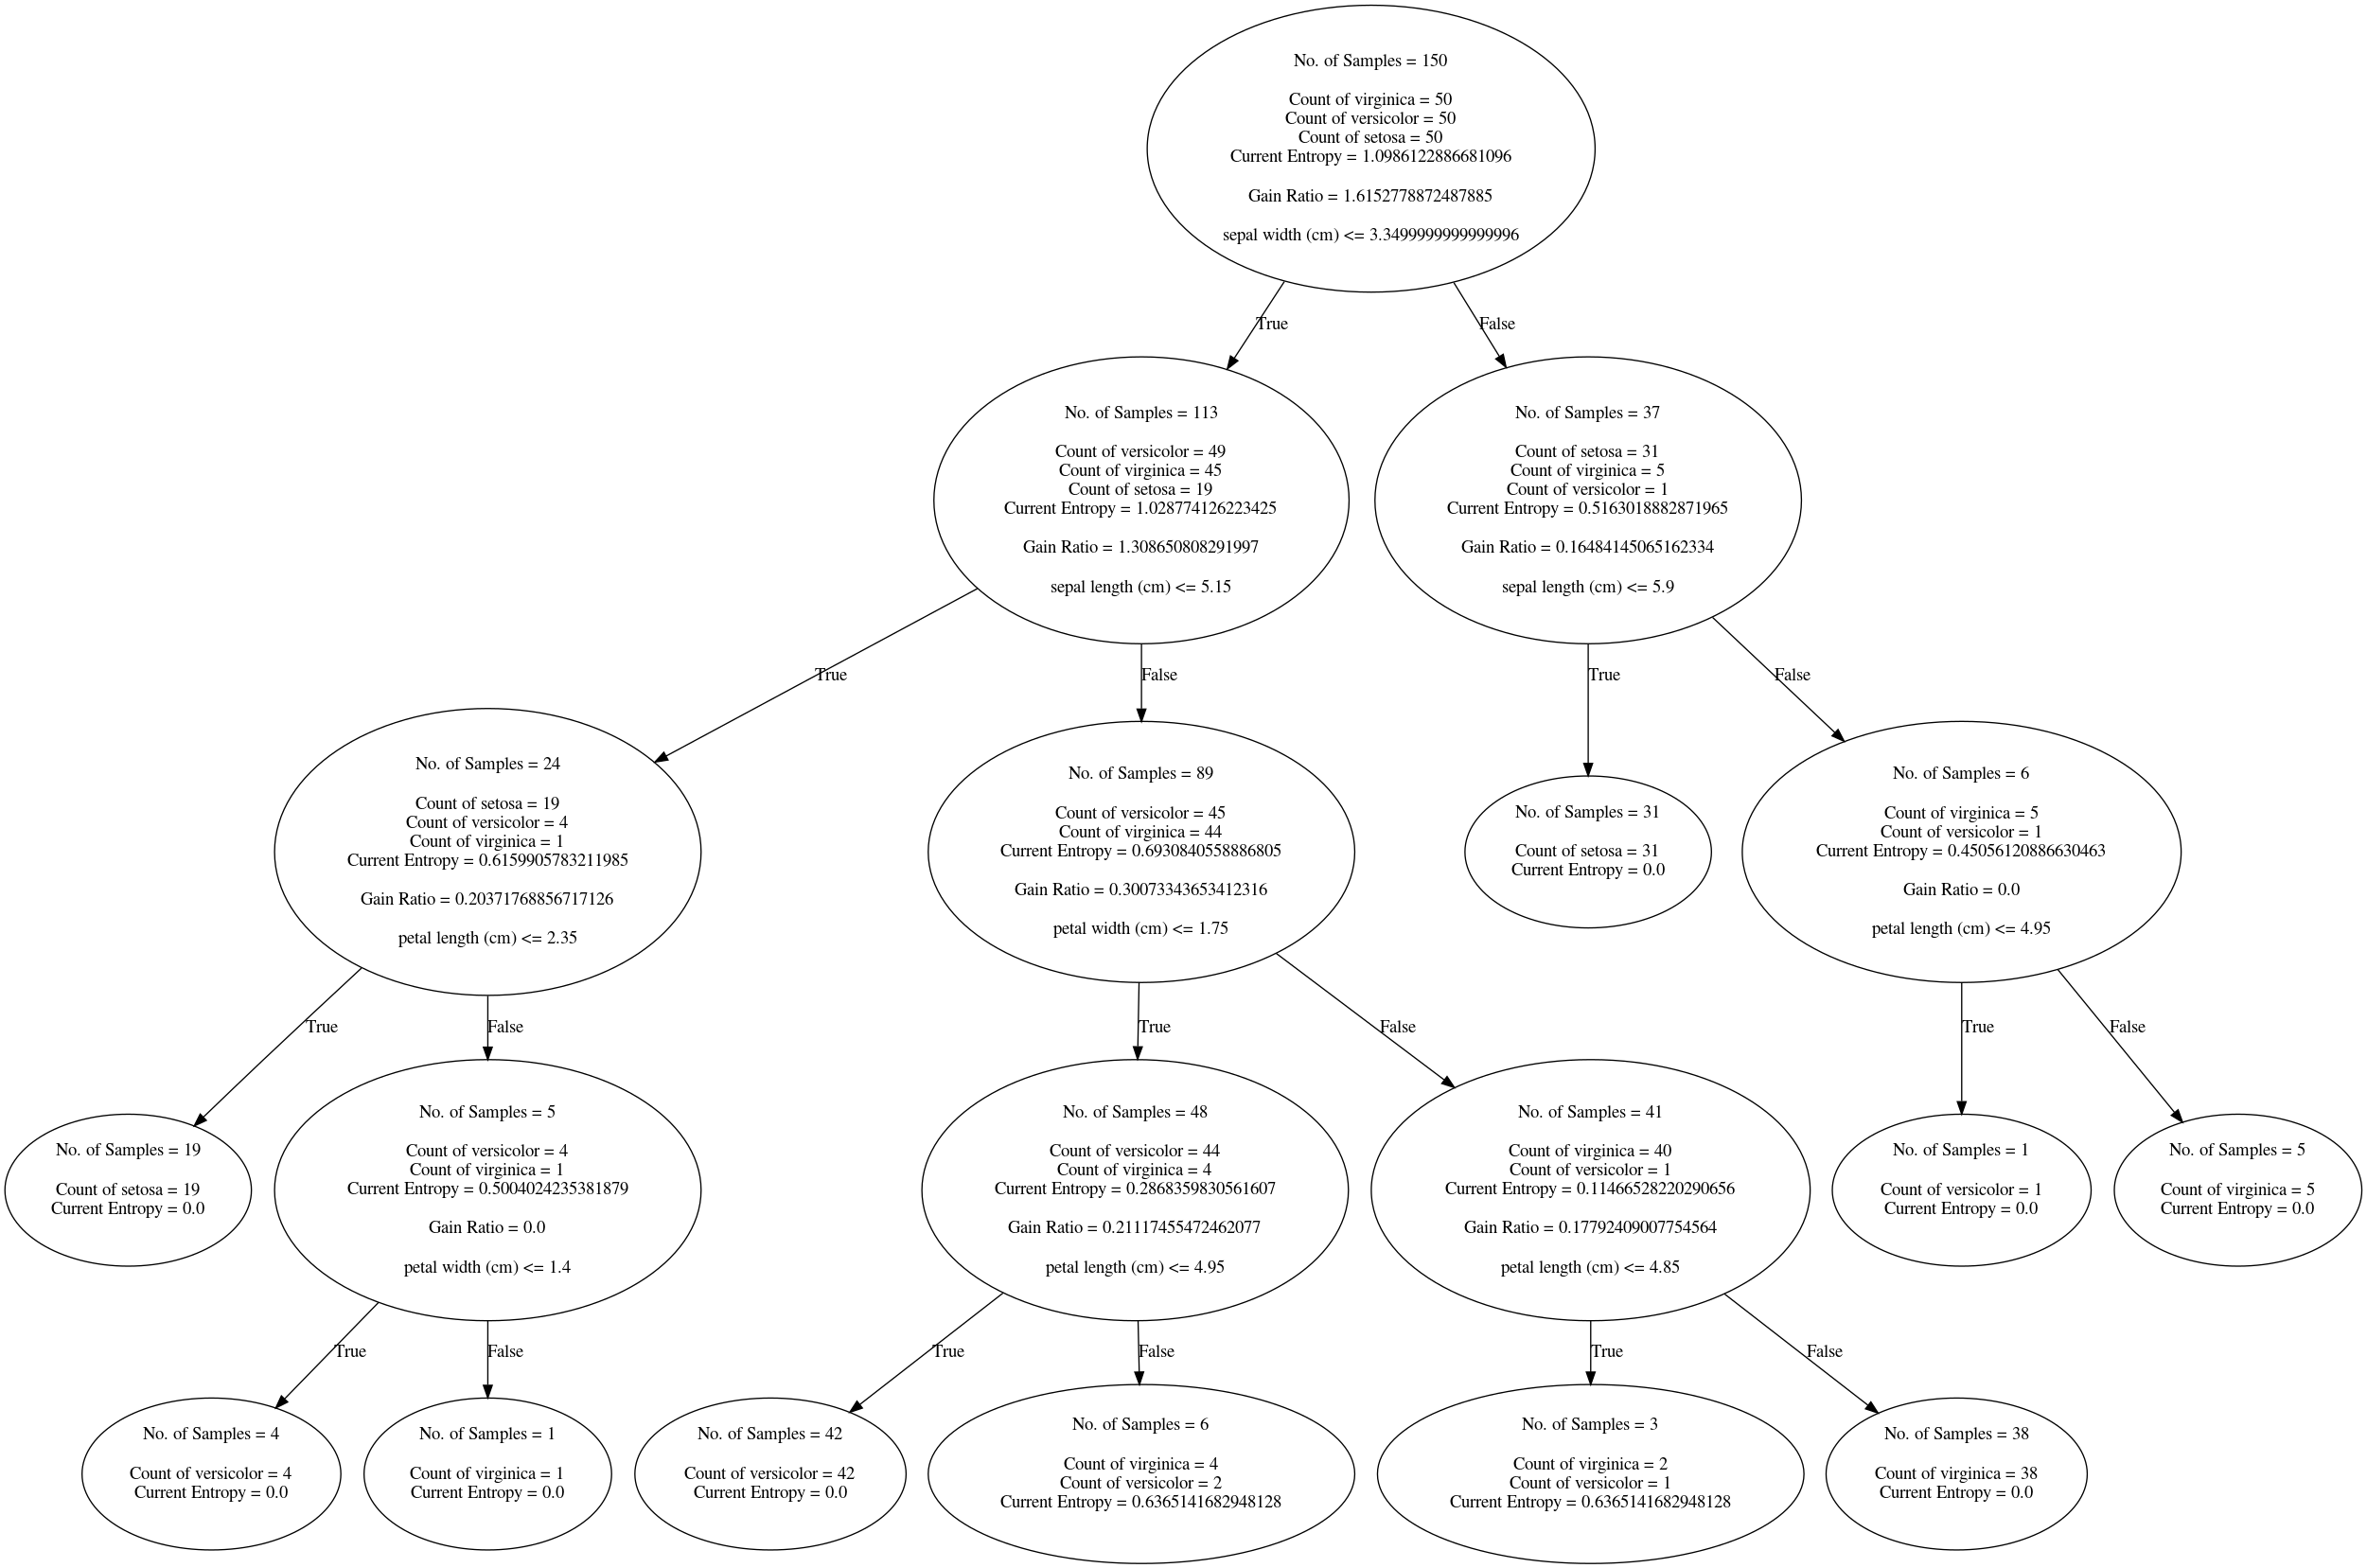

In [17]:
#to see the graph ...here..
from IPython.display import Image  
Image(main_graph.create_png())